In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler


from itertools import product
from sklearn import model_selection
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm

import glob

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!tar -xvzf "drive/My Drive/result.tar.gz"

Streaming output truncated to the last 5000 lines.
result/55.txt
result/550.txt
result/5500.txt
result/5501.txt
result/5502.txt
result/5503.txt
result/5504.txt
result/5505.txt
result/5506.txt
result/5507.txt
result/5508.txt
result/5509.txt
result/551.txt
result/5510.txt
result/5511.txt
result/5512.txt
result/5513.txt
result/5514.txt
result/5515.txt
result/5516.txt
result/5517.txt
result/5518.txt
result/5519.txt
result/552.txt
result/5520.txt
result/5521.txt
result/5522.txt
result/5523.txt
result/5524.txt
result/5525.txt
result/5526.txt
result/5527.txt
result/5528.txt
result/5529.txt
result/553.txt
result/5530.txt
result/5531.txt
result/5532.txt
result/5533.txt
result/5534.txt
result/5535.txt
result/5536.txt
result/5537.txt
result/5538.txt
result/5539.txt
result/554.txt
result/5540.txt
result/5541.txt
result/5542.txt
result/5543.txt
result/5544.txt
result/5545.txt
result/5546.txt
result/5547.txt
result/5548.txt
result/5549.txt
result/555.txt
result/5550.txt
result/5551.txt
result/5552.t

Получаем все текста, уже в красивом виде

In [0]:
way =  "drive/My Drive/Colab Notebooks"

In [0]:
all_files = glob.glob("result" + "/*.txt")

In [0]:
prefix_l = len ("/result")
docs_to_dict = {}
start = pd.DataFrame()
for f_name in tqdm(all_files):
    with open(f_name) as f:
        title =' '
        doc_id = int(f_name[prefix_l:-4])
        for num_line, line in enumerate(f):
            title = ' '.join(word for word in line.split() if len(word)>2)
        docs_to_dict[doc_id] = title
        
print(len(docs_to_dict))


28026


Функция делает словарь {группа: (документ, тайтл, таргет) }

In [0]:
train_data = pd.read_csv(way2+'/train_groups.csv')
traingroups_titledata = {}
for i in tqdm(range(len(train_data))):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = docs_to_dict[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Анализ длины доументов, размеров групп

In [0]:
ln = {}
mx = []
group_len = []
for new_group in tqdm(traingroups_titledata):
        docs = traingroups_titledata[new_group]
        ln = []
        group_len.append(len(docs))
        for j in range(0, len(docs)):
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            ln.append(len(words_j))
        mx.append(max(ln))

Minimum length of maximum from document = 636
Minimum length of group = 26


Text(0.5, 1.0, 'Maximum len_docs_in_group')

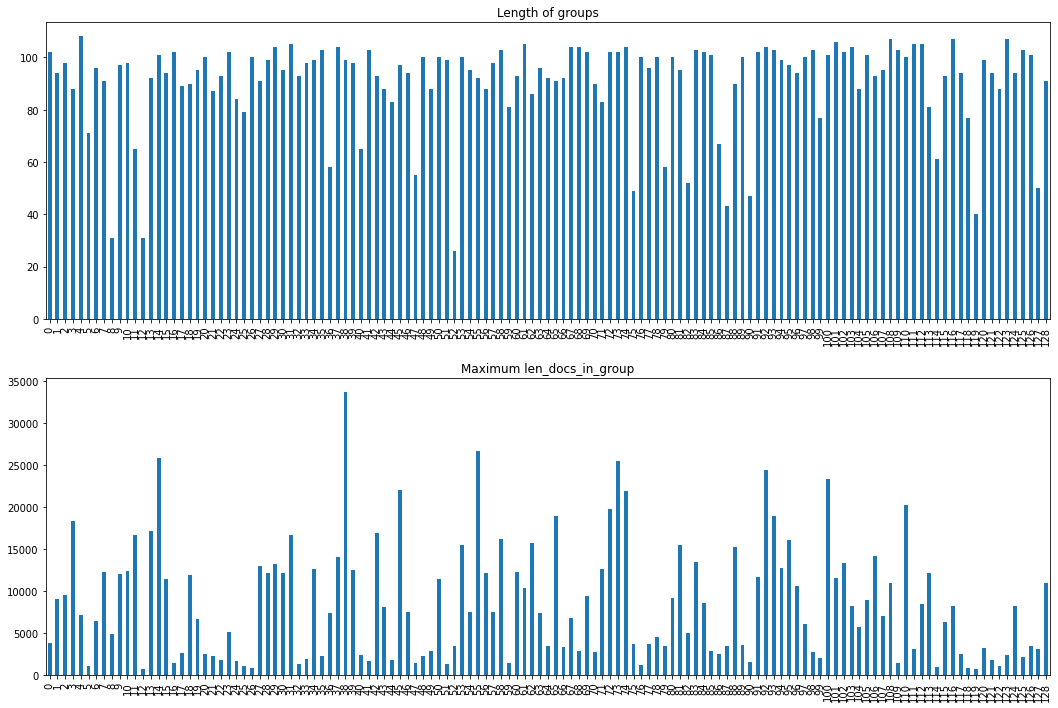

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1)
fig.set_figheight(12)
fig.set_figwidth(18)

print("Minimum length of maximum from document = {}".format(min(mx)))
print("Minimum length of group = {}".format(min(group_len)))
lens = pd.DataFrame()
lens['Maxlen_docs_in_group'] = mx
lens['Group_len'] = group_len
lens['Group_len'].plot.bar(ax=ax[0])
lens['Maxlen_docs_in_group'].plot.bar(ax=ax[1])
ax[0].set_title('Length of groups')
ax[1].set_title('Maximum len_docs_in_group')

Сразу понятно, что фич - пересечений не больше 26 может быть.


Еще возьмем фичу отклонение от средней длины документа

In [0]:
def getTrain(params):
    y_train = []
    X_train = []
    for new_group in tqdm(traingroups_titledata):
        docs = traingroups_titledata[new_group]
        ln = 0
        for j in range(0, len(docs)):
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            ln += len(words_j)
        ln /= len(docs)
        for k, (doc_id, title, target_id) in enumerate(docs):
            y_train.append(target_id)
            all_dist = []  
            words = set(title.strip().split())
            for j in range(0, len(docs)):
                if k == j:
                    continue
                doc_id_j, title_j, target_j = docs[j]
                words_j = set(title_j.strip().split())
                all_dist.append(len(words.intersection(words_j)))
            all_dist.sort(reverse=True)
            all_dist = all_dist[0:params]
            all_dist.append(abs(len(words) - ln))
            X_train.append(all_dist)
            
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    return X_train, y_train

In [0]:
a, b = getTrain(25)

In [0]:
a.shape

(11690, 26)

In [0]:
# for i in range (0, 129):
    # print(len(a[i]))
param = 9
def cut (params):
    cutX = []
    cutY = b
    for k in range(0, len(docs)):
        exp = list(a[0][0:9])
        exp = np.append(exp, a[0][-1])
        cutX.append(exp)
        
    cutX = np.array(cutX)
    scaler = StandardScaler()
    cutX = scaler.fit_transform(cutX)
    return cutX, cutY


In [0]:

# X_train = scaler.fit_transform(X_train)

In [0]:
from sklearn.ensemble import RandomForestClassifier as forest
splits = 5
kf = KFold(n_splits=splits)

def max_barrier(clf, X, y):
    """
    Подбираем порог линейной модели, 
    по достижению которого относим объект 
    к классу 1
    """
    (max_score, max_barr) = (0, 0)
    for barr in np.arange (0, 1, 0.01):
            probe = list(zip(*clf.predict_proba(X)))[1]
            score = f1_score(y, probe > barr)
#             print(barr, score)
            if score > max_score:
#                 print("AAaaaaaaaaaaaaaaaaa")
#                 print(barr, score)
                max_score, max_barr = score, barr
    return max_score, max_barr

def get_best(n_estimators, max_features, min_samples_leaf, max_depth, criterion, fiches_list):
    """
    Делаем кросс валидацию и, таким образом, 
    подбираем оптимальные параметры.
    """
    max_result = -1
    for k in product(n_estimators, max_features, min_samples_leaf, max_depth, criterion, fiches_list):
        print(k)
    for i, (n_estimators, max_features, min_samples_leaf, max_depth, criterion, fiches) in tqdm(list(enumerate(product(n_estimators, max_features, min_samples_leaf, max_depth, criterion, fiches_list)))):
        result = 0.0
        X_tran, y_tran = a, b
        for train_index, test_index in kf.split(X_tran):
            X_tr, X_tst = X_tran[train_index], X_tran[test_index]
            y_tr, y_tst = y_tran[train_index], y_tran[test_index]
            
            clf = forest(n_jobs=-1, n_estimators=n_estimators, max_features=max_features, min_samples_leaf=min_samples_leaf, max_depth=max_depth, criterion=criterion)
            clf.fit(X_tr, y_tr)
            
            score, barrier = max_barrier(clf, X_tst, y_tst)
#             print(clf.predict(X_tst))
#             print(penalty, C, l1_ratio, barrier)
#             probe = clf.predict_proba(X_tst))
            result += score
        
        result /= splits
        print(result, fiches)
        if result > max_result:
            max_result = result
            params = {'n_estimators': n_estimators, 'max_features': max_features, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth, 'criterion' : criterion, 'fiches': fiches}
            print(params)
    
    print('max_f1_score =', max_result, 'with', params)
    return params

In [0]:
# !unzip '/content/drive/My Drive/full_texts/stemming.zip'


In [0]:
# fiches_list = [9]#np.arange(1, 25, 1)
n_estimators = [500]
max_features = ['auto']
#max_features = ['auto']
min_samples_leaf = [5]
max_depth = [10]
criterion = ['gini']

print(fiches_list)

log_params = get_best(n_estimators, max_features, min_samples_leaf, max_depth, criterion, fiches_list)


[9]
(500, 'auto', 5, 10, 'gini', 9)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMe

In [0]:
X_train, y_train = getTrain(24)
X_train.shape

(11690, 25)

тест надо чуть поменять еще одна фича же

In [0]:
test_data = pd.read_csv('/content/drive/My Drive/fasttext/test_groups (1).csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    pair_id = new_doc['pair_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, pair_id, title))
    
X_test = []
pairs_id = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]        
    ln = 0
    for j in range(0, len(docs)):
        *_, title_j = docs[j]
        words_j = set(title_j.strip().split())
        ln += len(words_j)
    ln /= len(docs)
    for k, (doc_id, pair_id, title) in enumerate(docs):
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            *_, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        
        all_dist.sort(reverse=True)
        all_dist = all_dist[0:log_params['fiches']]
        all_dist.append(abs(len(words) - ln))
        X_test.append(all_dist)
        pairs_id.append(pair_id)
X_test = np.array(X_test)
# X_test = scaler.transform(X_test)
print(X_test.shape)

(16627, 25)


In [0]:
log_params

{'criterion': 'gini',
 'fiches': 24,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 500}

In [0]:
clf = forest(n_jobs=-1, n_estimators=500, criterion='gini', min_samples_leaf=5, max_depth=10, max_features='auto')
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
log_clf = LogisticRegression(C=100, penalty='elasticnet', solver='saga', l1_ratio=0.1, max_iter = 1000)
log_clf.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.1, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
X_test = scaler.fit_transform(X_test)

In [0]:
X_test.shape

(16627, 25)

In [0]:
X_test.shape

(16627, 21)

In [0]:
X_train[0]

array([ 1.06937234,  0.9127749 ,  1.08505406,  1.20602607,  0.71472857,
        0.78845347,  0.8569249 ,  0.91498833,  0.96408444,  1.01496731,
        1.05927733,  0.44406779,  0.47584257,  0.50709036,  0.53813518,
        0.56422119,  0.59301649,  0.62226706,  0.64569982,  0.66882456,
        0.69444798,  0.72130322,  0.74304063, -0.60914146])

In [0]:
log_clf.predict_proba(X_test)

NameError: ignored

In [0]:
X_test = scaler.fit_transform(X_test)
probes = list(zip(*log_clf.predict_proba(X_test)))[1]
predict = np.asarray(probes > log_params['barrier'], dtype=int)

In [0]:
predict = clf.predict(X_test)
predict

array([0, 1, 1, ..., 1, 1, 0])

In [0]:
test_data["target"] = pd.Series(predict)
with open("/content/drive/My Drive/fasttext/predict.csv", "w") as f:
    f.write(test_data.to_csv(columns=("pair_id", "target"), index=False))
print("good")

good
